# Basics methods for training and prediction using Keras

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    export DIR_PROJ= ...
    ...
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1="[\e[91m\]\u@:\[\e[32m\]\w/]$"
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


In [2]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


## Import packages

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging
import matplotlib.pyplot as plt
import os
import datetime
import numpy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [4]:
%load_ext tensorboard

## Define paths

In [5]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

In [6]:
print(data_dir)

/home/vera_luechinger/data


# Import local packages

In [7]:
import utils.model_metrics  as model_metrics

In [8]:
import importlib
importlib.reload(model_metrics);

## Getting and preprocessing data

In [9]:
# Setup logging verbosity
logging.set_verbosity(logging.INFO)

# Define the model's hyperparameters
STEPS_PER_EPOCH = 6
#BUFFER_SIZE = 10 # Use a much larger value for real code. 
#BATCH_SIZE = 64
BUFFER_SIZE = 10000
BATCH_SIZE = 500
NUM_EPOCHS = 25

In [10]:
def input_fn():
    import tensorflow as tf
    datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir=data_dir)
    mnist_train, mnist_test = datasets['train'], datasets['test']



    def scale(image, label):
        image = tf.cast(image, tf.float32)
#        image = tf.dtypes.cast(image, tf.float32)
        image /= 255
    
        return image, label

    #train_data = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    #test_data = mnist_test.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    train_data = mnist_train.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_data = mnist_test.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_data, test_data

In [11]:
train_data, test_data = input_fn()

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/vera_luechinger/data/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/mnist/3.0.0


In [12]:
# experimenting with keras inputs by combining training and test data
data = train_data.concatenate(test_data)
# abandoning this idea because:
#The argument validation_split (generating a holdout set from the training data) is not supported when 
#training from Dataset objects, since this features requires the ability to index the samples of the datasets, 
#which is not possible in general with the Dataset API.

In [13]:
#tf.data.experimental.cardinality(train_data)


In [14]:
#for l in test_data:
#    print(l[0].numpy()[0].shape)
#    break

## Build the model

In [15]:
def make_model():
    import tensorflow as tf
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        
        # play around from here on...
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        # ... until here
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [16]:
def make_model2():
    import tensorflow as tf
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),        
        tf.keras.layers.BatchNormalization(),

        # ... until here
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [17]:
model = make_model2()

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## Training the model

In [20]:
# implement tensorboard
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
print("train")
history=model.fit(train_data,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=NUM_EPOCHS,
                  verbose = 1,
                  validation_data=test_data,
                  validation_steps= 10000 / BATCH_SIZE,
                  callbacks=[tensorboard_callback])
                #validation_steps=TOTAL_VALIDATION_SAMPLES / BATCH_SIZE)

train
Train for 6 steps, validate for 20.0 steps
Epoch 1/25
6/6 [==============================] - 17s 3s/step - loss: 1.0973 - accuracy: 0.6610 - val_loss: 1.7568 - val_accuracy: 0.5800
Epoch 2/25
6/6 [==============================] - 11s 2s/step - loss: 0.4088 - accuracy: 0.8947 - val_loss: 1.5323 - val_accuracy: 0.6293
Epoch 3/25
6/6 [==============================] - 11s 2s/step - loss: 0.3293 - accuracy: 0.9143 - val_loss: 1.4005 - val_accuracy: 0.6948
Epoch 4/25
6/6 [==============================] - 11s 2s/step - loss: 0.2692 - accuracy: 0.9343 - val_loss: 1.3454 - val_accuracy: 0.6838
Epoch 5/25
6/6 [==============================] - 10s 2s/step - loss: 0.2506 - accuracy: 0.9320 - val_loss: 1.3145 - val_accuracy: 0.6835
Epoch 6/25
6/6 [==============================] - 11s 2s/step - loss: 0.2256 - accuracy: 0.9457 - val_loss: 1.2731 - val_accuracy: 0.7401
Epoch 7/25
6/6 [==============================] - 10s 2s/step - loss: 0.2222 - accuracy: 0.9407 - val_loss: 1.2579 - val_ac

In [22]:
%tensorboard --logdir logs/fit --host localhost

In [23]:
history.history

{'loss': [1.097313016653061,
  0.4087580392758052,
  0.32926860948403675,
  0.2691919555266698,
  0.2505653301874797,
  0.2256055250763893,
  0.22221465905507407,
  0.19737389187018076,
  0.19338351984818777,
  0.17719552665948868,
  0.15473641455173492,
  0.14125738541285196,
  0.14237350970506668,
  0.14209853361050287,
  0.12926528602838516,
  0.12401819477478664,
  0.12461366628607114,
  0.10659201815724373,
  0.12514692172408104,
  0.10101630414525668,
  0.10497261087099712,
  0.0962391197681427,
  0.10207529241840045,
  0.08677365506688754,
  0.08657253036896388],
 'accuracy': [0.661,
  0.8946667,
  0.91433334,
  0.9343333,
  0.932,
  0.9456667,
  0.9406667,
  0.9536667,
  0.95666665,
  0.9583333,
  0.96433336,
  0.9686667,
  0.9716667,
  0.966,
  0.973,
  0.972,
  0.9713333,
  0.98,
  0.97966665,
  0.9813333,
  0.977,
  0.9803333,
  0.97866666,
  0.983,
  0.983],
 'val_loss': [1.7567847430706025,
  1.5323216915130615,
  1.4004864394664764,
  1.3454123377799987,
  1.3145306527614

## Visualization

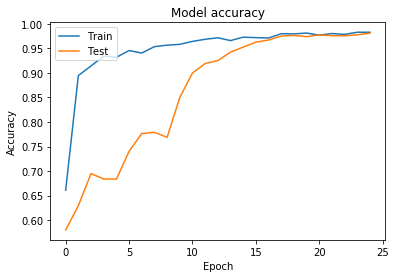

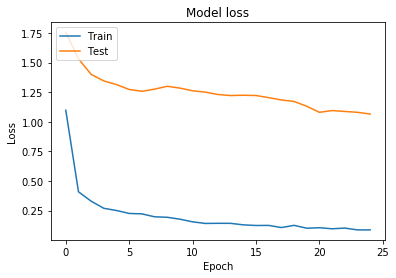

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluating the model

In [25]:
print("evaluate on training dataset")
model.evaluate(train_data,
              steps=6)

evaluate on training dataset
6/6 [==============================] - 5s 853ms/step - loss: 1.0621 - accuracy: 0.9870


[1.0621219078699748, 0.987]

In [26]:
print("evaluate on testing dataset")
model.evaluate(test_data,
               steps=1)

evaluate on testing dataset
1/1 [==============================] - 4s 4s/step - loss: 1.0720 - accuracy: 0.9840


[1.0719845294952393, 0.984]

## Doing prediction with our model

In [27]:
print("predict on one batch of data")
predict_on_batch = model.predict_on_batch(train_data)
print(model.predict_on_batch(train_data))

predict on one batch of data
tf.Tensor(
[[0.07041851 0.33041304 0.07675182 ... 0.12208893 0.05084039 0.05740935]
 [0.38536683 0.06041429 0.09495594 ... 0.06660831 0.05138543 0.06607442]
 [0.05020124 0.13727078 0.33883905 ... 0.05737596 0.09067312 0.05905106]
 ...
 [0.12562115 0.0663576  0.03159761 ... 0.35376588 0.02603702 0.15858741]
 [0.04865319 0.05438577 0.0998164  ... 0.05743349 0.08782643 0.05844954]
 [0.05864833 0.04954846 0.11583864 ... 0.05107174 0.3160097  0.117227  ]], shape=(500, 10), dtype=float32)


In [28]:
print("test on one batch of data")
print(model.test_on_batch(train_data))

test on one batch of data
[1.0798285, 0.985]


## Confusion Matrix

In [1]:
# confusion matrix
import tensorflow as tf
rounded_predictions = tf.math.argmax(predict_on_batch,1)
#test_labels = tf.math.argmax(train_data,1)
print(type(train_data))
print(type(predict_on_batch))
#cm = confusion_matrix(test_labels, rounded_predictions)

# I stopped here because debugging this issue might take too much time (for me). 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-2789da7adb8d>", line 2, in <module>
    import tensorflow as tf
  File "/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow/__init__.py", line 101, in <module>
    from tensorflow_core import *
  File "/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow_core/__init__.py", line 40, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 959, in _find_and_load_unlocked
  File "/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow/__init__.py", line 50, in __getattr__
    module = self._load()
  File "/home/.conda-env/env_multilingua

KeyboardInterrupt: 

## Notes
- Increasing the number of epochs to 10 increased the model accuracy which was to be expected but did not hugely increase test accuracy. ==> setup of the network in general not ideal, look for other things to adapt
- increasing the number of epochs to 50 or even 100 greatly improved the model (1)
- Adding 1 or 2 dense layers after the conv layers did not improve the prediction confidence much for few epochs. Model2 with 3 dense layers in classification for 50 or 100 epochs performed worse than model 1. LEss dense layers is more in terms of accuracy for both training and test
- increasing the number of nodes in the dense layer